Pair: Acton Town to South Ealing, Dijkstra Time: 0.000050, A* Time: 0.000036
Pair: Arsenal to Latimer Road, Dijkstra Time: 0.000237, A* Time: 0.000219
Pair: Chesham to Plaistow, Dijkstra Time: 0.000323, A* Time: 0.000305
Pair: Baker Street to Regent's Park, Dijkstra Time: 0.000039, A* Time: 0.000036
Pair: Bank to Woodford, Dijkstra Time: 0.000235, A* Time: 0.000226
Pair: Baker Street to Embankment, Dijkstra Time: 0.000077, A* Time: 0.000073
Pair: Aldgate East to Whitechapel, Dijkstra Time: 0.000031, A* Time: 0.000030
Pair: Heathrow Terminals 1, 2 & 3 to Canary Wharf, Dijkstra Time: 0.000240, A* Time: 0.000234
Pair: Wembley Park to Stratford, Dijkstra Time: 0.000720, A* Time: 0.000325
Pair: Epping to Wimbledon, Dijkstra Time: 0.000305, A* Time: 0.000302
Pair: Brixton to Oxford Circus, Dijkstra Time: 0.000059, A* Time: 0.000056
Pair: Watford to Moorgate, Dijkstra Time: 0.000194, A* Time: 0.000189


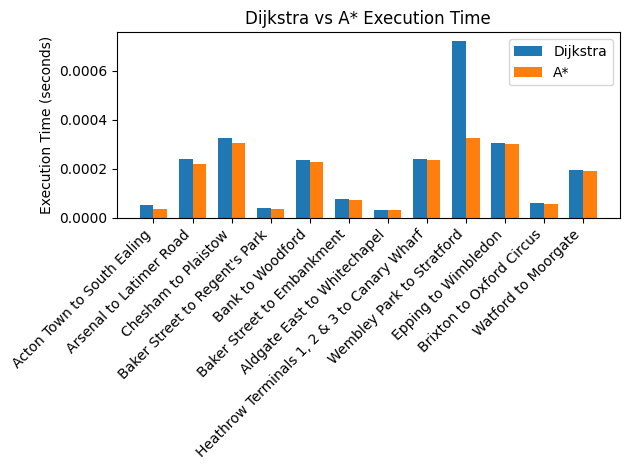

In [82]:

import csv
from math import radians, sqrt
import time
import matplotlib.pyplot as plt


class PriorityQueue:
    def __init__(self):
        self.elements = []

    def is_empty(self):
        return not self.elements

    def put(self, item, priority):
        self.elements.append((priority, item))
        self.elements.sort(reverse=True)

    def get(self):
        return self.elements.pop()[1]  
    
def dijkstra(graph, start, end):
    """
    Finds the shortest path from start to end using Dijkstra's algorithm.
    
    Parameters:
    - graph: The graph representation as a dict of dicts.
    - start: The starting node ID.
    - end: The ending node ID.
    
    Returns:
    - The shortest distance from start to end.
    - The path as a list of node IDs from start to end.
    """
    distance = {vertex: float('infinity') for vertex in graph}
    distance[start] = 0
    predecessor = {vertex: None for vertex in graph}
    pq = PriorityQueue()
    pq.put(start, 0)
    
    while not pq.is_empty():
        current_node = pq.get()
        
        if current_node == end:
            break

        for neighbor, weight in graph[current_node].items():
            alt_route = distance[current_node] + weight
            if alt_route < distance[neighbor]:
                distance[neighbor] = alt_route
                predecessor[neighbor] = current_node
                pq.put(neighbor, alt_route)
                
    # Reconstruct path from end to start using predecessors
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = predecessor[current]
    path.reverse()  # Reverse the path to start from the beginning
    
    return distance[end], path



def euclidean_distance(coord1, coord2):
    """
    Calculate the Euclidean distance between two points in a plane.
    
    Parameters:
    - coord1: Tuple containing (latitude, longitude) of the first point.
    - coord2: Tuple containing (latitude, longitude) of the second point.
    
    Returns:
    - The Euclidean distance between the two points.
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    # Convert latitudes and longitudes from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Calculate differences
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    
    # Simplify: Treat these differences as Cartesian distances
    # Note: This is a rough approximation and works better for short distances
    distance = sqrt(delta_lat**2 + delta_lon**2)
    
    return distance


def heuristic(station_id, destination_id):
    station_coord = (stations[station_id]['latitude'], stations[station_id]['longitude'])
    destination_coord = (stations[destination_id]['latitude'], stations[destination_id]['longitude'])
    return euclidean_distance(station_coord, destination_coord)

def A_Star(graph, source, destination, heuristic):

    open_set = PriorityQueue()
    open_set.put(source, 0 + heuristic(source, destination))  # Corrected this line
    predecessors = {source: None}
    actual_costs = {source: 0}

    while not open_set.is_empty():
        current_node = open_set.get()

        if current_node == destination:
            break  # When the destination is reached, exit the loop

        for neighbor, weight in graph[current_node].items():
            tentative_cost = actual_costs[current_node] + weight
            if neighbor not in actual_costs or tentative_cost < actual_costs[neighbor]:
                actual_costs[neighbor] = tentative_cost
                # Calculate total cost as the sum of actual cost so far and heuristic estimate to the goal
                total_cost = tentative_cost + heuristic(neighbor, destination)
                open_set.put(neighbor, total_cost)
                predecessors[neighbor] = current_node

    return predecessors, reconstruct_path(predecessors, source, destination)

def reconstruct_path(predecessors, start, end):
        if end not in predecessors:
            return []  # Path not found
        path = []
        while end is not None:
            path.append(end)
            end = predecessors.get(end)
        path.reverse()
        return path  


def parse_stations(file_path):
    """
    Parses the stations CSV file and returns a dictionary of stations.
    
    Parameters:
    - file_path: The path to the stations CSV file.
    
    Returns:
    - A dictionary where keys are station IDs and values are dictionaries
      containing latitude, longitude, and name of the station.
    """
    stations = {}
    with open(file_path, mode='r', encoding='utf-8') as infile:
        reader = csv.DictReader(infile)
        for row in reader:
            station_id = int(row["id"])
            stations[station_id] = {
                "latitude": float(row["latitude"]),
                "longitude": float(row["longitude"]),
                "name": row["name"]
            }
    return stations


def parse_connections(file_path):
    """
    Parses the connections CSV file and returns a list of connections.
    
    Parameters:
    - file_path: The path to the connections CSV file.
    
    Returns:
    - A list of tuples, each representing a connection between two stations.
      Each tuple contains (station1, station2, line, time).
    """
    connections = []
    with open(file_path, mode='r', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip the header
        for row in reader:
            connection = (int(row[0]), int(row[1]), int(row[2]), float(row[3]))
            connections.append(connection)
    return connections

stations_file_path = 'london_stations.csv'
connections_file_path = 'london_connections.csv'

stations = parse_stations(stations_file_path)
connections = parse_connections(connections_file_path)



def build_graph(connections):
    """
    Builds a graph from a list of connections.
    Each connection is a tuple (station1, station2, time).

    Parameters:
    - connections: A list of tuples, where each tuple contains
      (station1, station2, time).

    Returns:
    - A dictionary representing the graph, where keys are station IDs
      and values are dictionaries of neighboring stations and their respective times.
    """
    graph = {}

    for station1, station2, _, time in connections:
        # Initialize station1 and station2 in graph if they don't exist
        if station1 not in graph:
            graph[station1] = {}
        if station2 not in graph:
            graph[station2] = {}

        # Add the edge from station1 to station2 and vice versa
        graph[station1][station2] = time
        graph[station2][station1] = time  # Assuming bidirectional connections

    return graph


graph = build_graph(connections)

def measure_performance(graph, start_id, end_id, heuristic):
    # Measure Dijkstra's algorithm performance
    start_time = time.time()
    _, path_dijkstra = dijkstra(graph, start_id, end_id)
    dijkstra_time = time.time() - start_time

    # Measure A* algorithm performance
    start_time = time.time()
    _, path_astar = A_Star(graph, start_id, end_id, heuristic)
    astar_time = time.time() - start_time

    return dijkstra_time, astar_time


"""def count_line_changes(path, connections):
    station_pairs_to_lines = {}
    for conn in connections:
        station1, station2, line, _ = conn
        station_pairs_to_lines.setdefault((station1, station2), set()).add(line)
        station_pairs_to_lines.setdefault((station2, station1), set()).add(line)

    line_changes = 0
    current_line = None
    for i in range(len(path) - 1):
        station1, station2 = path[i], path[i + 1]
        possible_lines = station_pairs_to_lines.get((station1, station2), set())
        
        if not possible_lines.intersection({current_line}):
            current_line = possible_lines.pop() if possible_lines else None
            if i > 0:
                line_changes += 1
                
    return line_changes"""


def plot_performance_comparison(labels, dijkstra_times, astar_times, title='Dijkstra vs A* Execution Time'):
    """
    Plots a comparison of execution times between Dijkstra's and A* algorithms.

    Parameters:
    - labels: List of strings representing the labels for each station pair.
    - dijkstra_times: List of execution times for Dijkstra's algorithm.
    - astar_times: List of execution times for A* algorithm.
    - title: (Optional) Title for the plot.
    """
    x = range(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, dijkstra_times, width, label='Dijkstra')
    rects2 = ax.bar([p + width for p in x], astar_times, width, label='A*')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Execution Time (seconds)')
    ax.set_title(title)
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()

    plt.show()
    
station_pairs = [
    (1, 234),  # Short distance
    (10, 150),  # Medium distance
    (50, 200),  # Long distance
    (11, 212),  # Same Line, Short Distance
    (13, 301),  # Same Line, Long Distance
    (11, 87),   # Different Lines, No Transfers
    (3, 295),   # Different Lines, Multiple Transfers
    (117, 42),  # Heathrow Terminals 1, 2 & 3 to Canary Wharf
    (282, 247), # Wembley Park to Stratford
    (88, 299),  # Epping to Wimbledon
    (35, 192),  # Brixton to Oxford Circus
    (280, 167),  # Watford to Moorgate

]

# Collect data
labels = []
dijkstra_times = []
astar_times = []
line_changes_list = []

for start_id, end_id in station_pairs:
    # Adjust to unpack all four returned values
    dijkstra_time, _ = measure_performance(graph, start_id, end_id, lambda x, y: 0)
    astar_time, _ = measure_performance(graph, start_id, end_id, heuristic)
    
    # Append data to lists for plotting and analysis
    labels.append(f"{stations[start_id]['name']} to {stations[end_id]['name']}")
    dijkstra_times.append(dijkstra_time)
    astar_times.append(astar_time)
    
    # Optionally print out the information for verification
    print(f"Pair: {labels[-1]}, Dijkstra Time: {dijkstra_time:.6f}, A* Time: {astar_time:.6f}")


# Now, you can plot the comparison of times as before
plot_performance_comparison(labels, dijkstra_times, astar_times)




In [4]:
import heapq

def dijkstra1(graph, source, k):
    # Initialize distances to infinity and paths as empty lists
    distances = {node: float('infinity') for node in graph}
    paths = {node: [] for node in graph}
    relaxations = {node: 0 for node in graph} # Track relaxations
    
    # Distance to source is 0 and path is the source itself
    distances[source] = 0
    paths[source] = [source]
    relaxations[source] = 0
    
    # Priority queue: (distance, node)
    pq = [(0, source)]
    
    while pq:
        # Get the node with the smallest distance
        current_distance, current_node = heapq.heappop(pq)
        
        # For each neighbor of the current node
        for neighbor, weight in graph[current_node].items():
            distance = current_distance + weight
            
            # Relaxation condition
            if distance < distances[neighbor] and relaxations[neighbor] < k:
                distances[neighbor] = distance
                paths[neighbor] = paths[current_node] + [neighbor]
                relaxations[neighbor] += 1
                heapq.heappush(pq, (distance, neighbor))
                
    return distances, paths
def dijkstra2(graph, source, k):

    dist = {node: float('inf') for node in graph}
    dist[source] = 0
    path = {node: [] for node in graph}
    path[source] = [source]
    unvisited = set(graph.keys())
    relaxations = {node: 0 for node in graph}

    while unvisited:
        current_node = None
        current_distance = float('inf')
        for node in unvisited:
            if dist[node] < current_distance:
                current_node = node
                current_distance = dist[node]

        if current_node is None:
            break

        unvisited.remove(current_node)

        if relaxations[current_node] >= k:
            continue

        for neighbor, weight in graph[current_node].items():
            new_distance = current_distance + weight

            if new_distance < dist[neighbor]:
                dist[neighbor] = new_distance
                path[neighbor] = path[current_node] + [neighbor]
                relaxations[neighbor] += 1

    return dist, path
# Example graph
graph = {
    0: {1: 4, 7: 8},
    1: {0: 4, 2: 8, 7: 11},
    2: {1: 8, 3: 7, 8: 2},
    3: {2: 7, 4: 9, 5: 14},
    4: {3: 9, 5: 10},
    5: {2: 4, 3: 14, 4: 10, 6: 2},
    6: {5: 2, 7: 1, 8: 6},
    7: {0: 8, 1: 11, 6: 1, 8: 7},
    8: {2: 2, 6: 6, 7: 7},
}

# Test the function
source = 0
k = 2
distances1, paths1 = dijkstra1(graph, source, k)
distances2, paths2 = dijkstra2(graph, source, k)
print("Distances1:", distances1)
print("Paths1:", paths1)
print("Distances2:", distances2)
print("Paths2:", paths2)

if (distances1 == distances2) and (paths1 == paths2):
    print("Both functions produced the same results.")

Distances1: {0: 0, 1: 4, 2: 12, 3: 19, 4: 21, 5: 11, 6: 9, 7: 8, 8: 14}
Paths1: {0: [0], 1: [0, 1], 2: [0, 1, 2], 3: [0, 1, 2, 3], 4: [0, 7, 6, 5, 4], 5: [0, 7, 6, 5], 6: [0, 7, 6], 7: [0, 7], 8: [0, 1, 2, 8]}
Distances2: {0: 0, 1: 4, 2: 12, 3: 19, 4: 21, 5: 11, 6: 9, 7: 8, 8: 14}
Paths2: {0: [0], 1: [0, 1], 2: [0, 1, 2], 3: [0, 1, 2, 3], 4: [0, 7, 6, 5, 4], 5: [0, 7, 6, 5], 6: [0, 7, 6], 7: [0, 7], 8: [0, 1, 2, 8]}
Both functions produced the same results.
